In [1]:
#importing the libraries needed
import numpy as np
import pandas as pd
import tensorflow as tf
from math import floor, ceil
import sklearn as sk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Bidirectional, LSTM,Masking,Embedding
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, make_scorer
from sklearn.model_selection import cross_validate,train_test_split,GridSearchCV
from sklearn.preprocessing import normalize
from tensorflow.keras.models import load_model 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as pyplot
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import time
import json
import ast
import os


# Linear Algebra Flipped

In [2]:
data_path = '../longer_features/'

# set week type, feature types, and courses here
week_type = 'eq_week'
feature_types = ['akpinar_et_al', 'boroujeni_et_al', 
                 'chen_cui', 'he_et_al', 'lalle_conati','lemay_doleck', 
                 'marras_et_al', 'mbouzao_et_al', 'mubarak_et_al', 'wan_et_al']
marras_et_al_id = feature_types.index('marras_et_al')
akpinar_et_al_id = feature_types.index('akpinar_et_al')
courses = ['geomatique_003']

# boolean: if True, remove features directly related to student success in weekly quizzes:
# student shape, competency alignment, competency strength
remove_obvious = True

# set number of epochs to train models for each course:
params = {}
for course in courses:
    params[course] = {'num_epochs':12}

In [3]:
# Loading the features
feature_list = {}

for course in courses:
    feature_type_list = []
    for feature_type in feature_types:
    
        filepath = data_path + week_type + '-' + feature_type + '-' + course
        feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
        print(feature_type, feature_current.shape)
        print(np.count_nonzero(np.isnan(feature_current).any(axis=0)))
        feature_norm = feature_current.reshape(-1,feature_current.shape[2] )
#         print(feature_norm.shape)
        feature_type_list.append(pd.DataFrame(feature_norm))
    feature_list[course] = feature_type_list

print('course: ', courses)
print('week_type: ', week_type)
print('feature_type: ', feature_types)

akpinar_et_al (2149, 15, 4100)
0
boroujeni_et_al (2149, 15, 3)
45
chen_cui (2149, 15, 13)
30
he_et_al (2149, 15, 3)
28
lalle_conati (2149, 15, 22)
81
lemay_doleck (2149, 15, 10)
90
marras_et_al (2149, 15, 7)
69
mbouzao_et_al (2149, 15, 3)
20
mubarak_et_al (2149, 15, 13)
120
wan_et_al (2149, 15, 13)
120
course:  ['geomatique_003']
week_type:  eq_week
feature_type:  ['akpinar_et_al', 'boroujeni_et_al', 'chen_cui', 'he_et_al', 'lalle_conati', 'lemay_doleck', 'marras_et_al', 'mbouzao_et_al', 'mubarak_et_al', 'wan_et_al']


In [4]:
def clean_name(feature):
    id = feature.find('<')
    if id==-1:
        return feature
    fct = feature[id+9:id+14].strip()
    return feature[0:id]+fct

def clean_akp_name(feature):
    feature = feature.lower()
    if feature.find("(")!=-1:
        feature = feature[1:-1]
        feature = feature.replace(', ', '-')
    return feature
    

In [5]:
# Loading feature names
feature_names= dict()

for feature_type in feature_types:
    
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/settings.txt'
    file = open(filepath, "r")
    contents = file.read()
    dictionary = ast.literal_eval(contents)
    file.close()
    
    feature_type_name = dictionary['feature_names']
    
    # reformat feature names
    # ex: time_sessions_<function sum at 0x7f3bd02cc9d0> -> time_sessions_sum
    feature_type_name = [clean_name(x) for x in feature_type_name]
    
    # for akpinar_et_al, just use the features listed below
    if feature_type == 'akpinar_et_al': 
        feature_type_name = [clean_akp_name(x) for x in feature_type_name]
        akp_mask = np.where(np.isin(feature_type_name, 
                 ["total_clicks", "number_sessions", "time_in__video_sum", "time_in__problem_sum",
                  'problem.check-problem.check-problem.check', 
                  'problem.check-problem.check-video.load', 
                  'video.play-video.play-video.play',
                  'video.play-video.pause-video.load',
                  'video.play-problem.check-problem.check',
                  'video.play-video.stop-video.play',
                  'video.pause-video.speedchange-video.play',
                  'video.stop-video.play-video.seek',
                  'video.stop-problem.check-video.load']))
        print(akp_mask)
        feature_type_name = list(np.array(feature_type_name)[akp_mask[0]])
        feature_list[course][akpinar_et_al_id] = feature_list[course][akpinar_et_al_id][akp_mask[0]]
        
        
    feature_names[feature_type] = feature_type_name
    print(feature_type, len(feature_type_name))

if remove_obvious: 
    # drop 'student shape', 'competency strength', 'competency alignment' in marras at al
    
    mr_mask = np.where(np.isin(feature_names['marras_et_al'], 
                 ['student_shape', 'competency_strength', 'competency_alignment']))
    
    new_marras = np.delete(np.array(feature_names['marras_et_al']), mr_mask[0])
    feature_names['marras_et_al'] = new_marras
    
    for course in courses: 
        new_features = feature_list[course][marras_et_al_id].drop(mr_mask[0], axis=1)
        feature_list[course][marras_et_al_id] = new_features


(array([   0,    1,    2,    3,   86,  517,  550,  582,  618, 1063, 1125,
       1637, 1642]),)
akpinar_et_al 13
boroujeni_et_al 3
chen_cui 13
he_et_al 3
lalle_conati 22
lemay_doleck 10
marras_et_al 7
mbouzao_et_al 3
mubarak_et_al 13
wan_et_al 13


In [6]:
# Bidirection LSTM definition

def bidirectional_lstm(x_train, y_train, x_test, y_test, x_val, y_val, 
                       week_type, feature_types, course,n_weeks,n_features, 
                       hidden_feature_num=[8, 8], batch_size=32, num_epochs=100):
    n_dims = x_train.shape[0]
    look_back = 3
    # LSTM
    # define model
    lstm = Sequential()
    ###########Reshape layer################
    lstm.add(tf.keras.layers.Reshape((n_weeks, n_features), input_shape=(n_weeks*n_features,)))
    ##########deleting the 1.001 max row added###########
    lstm.add(Masking(mask_value = 1))
    lstm.add(Bidirectional(LSTM(hidden_feature_num[0], return_sequences=True)))
    lstm.add(Bidirectional(LSTM(hidden_feature_num[1])))
    # Add a sigmoid Dense layer with 1 units.
    lstm.add(Dense(1, activation='sigmoid'))
    # compile the model
    lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # fit the model
    history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=batch_size, verbose=1)
    # evaluate the model
    y_pred = lstm.predict(x_test)
    y_pred = [1 if y[0] >= 0.5 else 0 for y in y_pred]
    # evaluate the model
    model_params = {'model': 'LSTM-bi', 'epochs': num_epochs, 
                    'hidden_feature_num': hidden_feature_num,
                    'batch_size': batch_size, 'loss': 'binary_cross_entropy'}
    scores = evaluate(None, x_test, y_test, week_type, feature_types, course, 
                      hidden_feature_num,
                      y_pred=y_pred, 
                      model_name="TF-LSTM-bi", model_params=model_params)
    
    file = '../models/' + course + '_biLSTM_results.json'
    with open(file, 'w') as f: 
        json.dump(scores, f)
    
    lstm.save('../models/lstm_bi_'+ course + "_" + current_timestamp)
    return history, scores

In [7]:
def plot_history(history, filename):
    fig, axs = pyplot.subplots(1,1, figsize=(6,3))
    sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label='train', ax=axs)
    sns.lineplot(x=range(len(history.history['loss'])), y=history.history['val_loss'], label='test',ax=axs)
    axs.set_title('Loss ' + filename)
    axs.set_xlabel('epoch')
    axs.set_ylabel('loss')
#     pyplot.savefig(filename+'_loss.png')

    fig, axs = pyplot.subplots(1,1, figsize=(6,3))
    sns.lineplot(x=range(len(history.history['loss'])), y=history.history['accuracy'], label='train', ax=axs)
    sns.lineplot(x=range(len(history.history['loss'])), y=history.history['val_accuracy'], label='test',ax=axs)
    axs.set_title('Accuracy '+ filename)
    axs.set_xlabel('epoch')
    axs.set_ylabel('accuracy')
    #pyplot.savefig(filename+'_acc.png')

In [8]:
def evaluate(model, x_test, y_test, week_type, feature_type, course, 
             hidden_feature_num,
             model_name=None, model_params=None, y_pred=None):
    scores={}
    scores['test_acc'] = accuracy_score(y_test, y_pred)
    scores['test_bac'] = balanced_accuracy_score(y_test, y_pred)
    scores['test_prec'] = precision_score(y_test, y_pred)
    scores['test_rec'] = recall_score(y_test, y_pred)
    scores['test_f1'] = f1_score(y_test, y_pred)
    scores['test_auc'] = roc_auc_score(y_test, y_pred)
    scores['feature_type'] = feature_type
    scores['week_type'] = week_type
    scores['course'] = course
    scores['hidden_feature_num_1'] = hidden_feature_num[0]
    scores['hidden_feature_num_2'] = hidden_feature_num[1]
    scores['data_balance'] = sum(y)/len(y)
    
    return scores

In [9]:
# fillNaN function replaces NaNs in each week with the minimum of the feature over all weeks

def fillNaN(feature):
    shape = feature.shape
    feature_min = np.nanmin(feature.reshape(-1,shape[2]),axis=0)
    feature = feature.reshape(-1,shape[2])
    inds = np.where(np.isnan(feature))
    feature[inds] = np.take(feature_min.reshape(-1), inds[1])
    feature = feature.reshape(shape)
    return feature

In [10]:
# load data and normalize

def load_labels(course):
    feature_type = "boroujeni_et_al"
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/feature_labels.csv'
    labels = pd.read_csv(filepath)['label-pass-fail']
    labels[labels.shape[0]] = 1
    return labels.values

def load_features(course):
    feature_list = []
    selected_features = []
    total_features = set()
    num_weeks = 0
    num_features = 0
    for i,feature_type in enumerate(feature_types):
        try:
            filepath = data_path + week_type + '-' + feature_type + '-' + course 
            feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
            print(feature_type)
            shape = feature_current.shape
    #         print(shape)

            if remove_obvious and feature_type=='marras_et_al':
                feature_current = np.delete(feature_current, mr_mask, axis=2)

            if feature_type=='akpinar_et_al':
                print(akp_mask[0])
                akp_mask_dl = np.delete(list(range(shape[2])), akp_mask[0])
                feature_current = np.delete(feature_current, akp_mask_dl, axis=2)

            shape = feature_current.shape
    #         print(shape)
            if i==0:
                num_weeks = shape[1]

            selected = np.arange(shape[2])
            # drop existed features
            exist_mask = []
            for i, name in enumerate(feature_names[feature_type]):
                if name in total_features:
                    exist_mask.append(i)
                else:
                    total_features.add(name)
    #         print(exist_mask, feature_current.shape)
            feature_current = np.delete(feature_current, exist_mask, axis=2)
            selected = np.delete(selected, exist_mask)

#             print(feature_current.shape)
            nonNaN = (shape[0]*shape[1] - np.isnan(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0) > 0)
            feature_current = feature_current[:,:,nonNaN]
            selected = selected[nonNaN]
            feature_current = fillNaN(feature_current)
            nonZero = (abs(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0)>0)
            selected = selected[nonZero]
            feature_current = feature_current[:,:,nonZero]


    #         print(feature_type, feature_current.shape)
            selected_features.append(np.array(feature_names[feature_type])[[selected]])

            num_features += len(np.array(feature_names[feature_type])[[selected]])


            ##### Normalization with min-max. Added the artifical 1.001 max row for solving the same min max problem
            ##### for features with max=0 I added 1 instead of 1.001 of maximum

            features_min = feature_current.min(axis=0).reshape(-1)
            features_max = feature_current.max(axis=0)
            features_max = np.where(features_max==0,np.ones(features_max.shape),features_max)
            max_instance = 1.001*features_max
            feature_current = np.vstack([feature_current,max_instance.reshape((1,)+max_instance.shape)])
            features_max = features_max.reshape(-1)
            feature_norm = (feature_current.reshape(shape[0]+1,-1)-features_min)/(1.001*features_max-features_min)
            feature_current = feature_norm.reshape(-1,feature_current.shape[1],feature_current.shape[2] )
            print(feature_current.shape)
            feature_list.append(feature_current)
        except:
            print('{} is not valiad'.format(feature_type))
        
    features = np.concatenate(feature_list, axis=2)
#     print(features.shape)
    features = features.reshape(features.shape[0],-1)
#     features = pd.DataFrame(features, columns=total_features)
    
    SHAPE = features.shape
    # print(np.isnan(features[0,0,-1]))
    print('features shape:', features.shape)
    print('course: ', course)
    print('week_type: ', week_type)
    print('feature_type: ', feature_types)
    print(selected_features)
    return features, selected_features, num_weeks, num_features


In [11]:
labels = {}
features = {}
selected_features = {}


for course in courses:
    print(course)
    labels[course] = load_labels(course)
    feats, sel_feats, num_weeks, num_features = load_features(course)
    features[course] = feats
    selected_features[course] = sel_feats
    params[course]['num_weeks'] = num_weeks
    params[course]['num_features'] = num_features

geomatique_003
akpinar_et_al
[   0    1    2    3   86  517  550  582  618 1063 1125 1637 1642]
(2150, 15, 10)
boroujeni_et_al
(2150, 15, 3)
chen_cui
(2150, 15, 9)
he_et_al
(2150, 15, 3)
lalle_conati
(2150, 15, 13)
lemay_doleck
(2150, 15, 8)
marras_et_al
(2150, 15, 4)
mbouzao_et_al
(2150, 15, 1)
mubarak_et_al
(2150, 15, 4)
wan_et_al
(2150, 15, 11)
features shape: (2150, 990)
course:  geomatique_003
week_type:  eq_week
feature_type:  ['akpinar_et_al', 'boroujeni_et_al', 'chen_cui', 'he_et_al', 'lalle_conati', 'lemay_doleck', 'marras_et_al', 'mbouzao_et_al', 'mubarak_et_al', 'wan_et_al']
[array(['total_clicks', 'number_sessions', 'time_in__video_sum',
       'time_in__problem_sum', 'video.pause-video.speedchange-video.play',
       'video.play-video.pause-video.load',
       'video.play-video.play-video.play',
       'video.play-problem.check-problem.check',
       'problem.check-problem.check-video.load',
       'problem.check-problem.check-problem.check'], dtype='<U41'), array(['regula

/var/folders/16/kn9v95ss6kx75q2kjs2mn9jm0000gn/T/ipykernel_98857/1205422244.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  selected_features.append(np.array(feature_names[feature_type])[[selected]])
/var/folders/16/kn9v95ss6kx75q2kjs2mn9jm0000gn/T/ipykernel_98857/1205422244.py:62: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  num_features += len(np.array(feature_names[feature_type])[[selected]])


In [12]:
course = 'geomatique_003'
final_features = dict()

for i, feature_type in enumerate(feature_types):
    final_features[feature_type] = list(selected_features[course][i])
    
print(final_features)

{'akpinar_et_al': ['total_clicks', 'number_sessions', 'time_in__video_sum', 'time_in__problem_sum', 'video.pause-video.speedchange-video.play', 'video.play-video.pause-video.load', 'video.play-video.play-video.play', 'video.play-problem.check-problem.check', 'problem.check-problem.check-video.load', 'problem.check-problem.check-problem.check'], 'boroujeni_et_al': ['regularity_peak_dayhour', 'regularity_periodicity_m1', 'delay_lecture'], 'chen_cui': ['time_sessions_sum', 'time_sessions_mean', 'time_between_sessions_std', 'time_sessions_std', 'total_clicks_weekday', 'total_clicks_weekend', 'ratio_clicks_weekend_day', 'total_clicks_video', 'total_clicks_problem'], 'he_et_al': ['attendance_rate', 'utilization_rate', 'watching_ratio'], 'lalle_conati': ['total_clicks_Video.Load', 'weekly_prop_watched_mean', 'weekly_prop_replayed_mean', 'weekly_prop_interrupted_mean', 'total_clicks_Video', 'frequency_action_Video', 'frequency_action_Video.Load', 'frequency_action_Video.Play', 'frequency_actio

In [13]:
file = '../Explainability/selected_features/' + course + '_after.json'
with open(file, 'w') as f: 
    json.dump(final_features, f)

2022-05-17 18:27:12.613318: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(1720, 990) (215, 990) (215, 990)
(1720,) (215,) (215,)
bidirectional_lstm
Epoch 1/12
54/54 [==============================] - 14s 76ms/step - loss: 0.3447 - accuracy: 0.9081 - val_loss: 0.1061 - val_accuracy: 0.9581
Epoch 2/12
54/54 [==============================] - 1s 15ms/step - loss: 0.0902 - accuracy: 0.9616 - val_loss: 0.0838 - val_accuracy: 0.9814
Epoch 3/12
54/54 [==============================] - 1s 16ms/step - loss: 0.0769 - accuracy: 0.9727 - val_loss: 0.0777 - val_accuracy: 0.9767
Epoch 4/12
54/54 [==============================] - 1s 16ms/step - loss: 0.0670 - accuracy: 0.9733 - val_loss: 0.0666 - val_accuracy: 0.9814
Epoch 5/12
54/54 [==============================] - 1s 16ms/step - loss: 0.0705 - accuracy: 0.9721 - val_loss: 0.0748 - val_accuracy: 0.9767
Epoch 6/12
54/54 [==============================] - 1s 16ms/step - loss: 0.0620 - accuracy: 0.9762 - val_loss: 0.0733 - val_accuracy: 0.9721
Epoch 7/12
54/54 [==============================] - 1s 16ms/step - loss: 0.059

2022-05-17 18:27:46.750562: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/lstm_bi_geomatique_003_1652804832.6081/assets


INFO:tensorflow:Assets written to: ../models/lstm_bi_geomatique_003_1652804832.6081/assets


metric          value    
test_acc        0.9814   
test_bac        0.9646   
test_prec       0.9949   
test_rec        0.9848   
test_f1         0.9898   
test_auc        0.9646   
week_type       eq_week  
course          geomatique_003 
hidden_feature_num_1 64       
hidden_feature_num_2 32       
data_balance    0.9051   


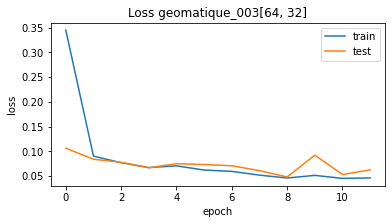

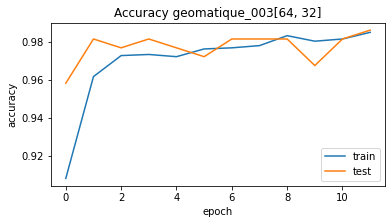

In [14]:
# training models
# fts

fts = features[course].copy()
target = labels[course].copy()
y=target
    
fts = fts.reshape(fts.shape[0], -1)
train_size = 0.8
x_train, x_rem, y_train, y_rem = train_test_split(fts, target, train_size=train_size, random_state=25)
x_test, x_val, y_test, y_val = train_test_split(x_rem, y_rem, train_size=0.5, random_state=25)
# print(year+':')
print(x_train.shape,x_test.shape,x_val.shape)
print(y_train.shape,y_test.shape,y_val.shape)


num_weeks = params[course]['num_weeks']
num_features = params[course]['num_features']
num_epochs = params[course]['num_epochs']

hidden_feature_num = [64,32]

current_timestamp = str(time.time())[:-2]
model=bidirectional_lstm
print(model.__name__)
history, scores = model(x_train, y_train, x_test, y_test, x_val, y_val,
                      week_type, feature_types, course, n_weeks=num_weeks,
                        hidden_feature_num=hidden_feature_num,
                      n_features=num_features, num_epochs=num_epochs)
print("{:<15} {:<8} ".format('metric','value'))
for ke, v in scores.items():
    if isinstance(v, float):
        v=round(v, 4)
    if ke!="feature_type":
        print("{:<15} {:<8} ".format(ke, v))
run_name = model.__name__ + "_" + course + "_" + current_timestamp
filename = str(course) + str(hidden_feature_num)
fig = plot_history(history=history, filename=filename)
